# DATA 512: Homework A4 - A7, by Ryan Williams

This notebook consists of 3 main parts:

* Part 1 is an analysis of whether masking policies changed the progression of confirmed COVID-19 cases in Cuyahoga County from February 1, 2020 through October 15, 2021.


* Part 2 is an analysis of whether Cuyahoga County's unemployment rate correlated with changes COVID-19 cases.


* Part 3 is an analysis of whether Cuyahoga's unemployment rate was impacted differently compared to other counties in the Cleveland-Elyria metropolitan area.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.regressionplots import abline_plot
from causalimpact import CausalImpact
from scipy import misc
from scipy.integrate import odeint
from datetime import date, timedelta

## Part 1: How did masking policies change the progression of COVID-19 cases in Cuyahoga County, OH?

In this analysis, we determine whether masking policies impacted the progression of COVID-19 in Cuyahoga using a counterfactual methodology, where we compare our observations to time series forecasts that assume no change in masking policy

### Step 1: Read in data

Read in the necessary data on Cuyahoga County, COVID-19 cases over time, and the time periods for mask mandates

In [2]:
county = pd.read_csv("./data/US County Assignments.csv")
cases = pd.read_csv("./data/RAW_us_confirmed_cases.csv")
maskMand = pd.read_csv("./data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
maskComp = pd.read_csv("https://github.com/nytimes/covid-19-data/raw/master/mask-use/mask-use-by-county.csv")

### Step 2: Clean data
In this section we go through all the steps needed to prepare the data for analysis in Part 1

Start by pulling the name of the county we're interested in (which turns out to be Cuyahoga) and saving the population number to use later

In [3]:
# get my assigned county (and state, in case county isn't unique)
stateName = county[county['UWNetID'] == 'lrw0102']['State'].values[0]
countyName = county[county['UWNetID'] == 'lrw0102']['County'].values[0]
countyStats = county[county['UWNetID'] == 'lrw0102'][['County','Area_mi^2','Population_2020_Census']]

# Population based on 2020 census
pop = 1264817

Next we filter the COVID-19 case and mask mandate/compliance data down to Cuyahoga only, and keep only the columns we need

In [4]:
# get cases, mask mandates, and mask compliance in this county
countyCases = cases[cases['Admin2'] == countyName]
countyMandates = maskMand[maskMand['County_Name'] == countyName + " " + "County"]
countyCompliance = maskComp[maskComp['COUNTYFP'] == countyCases['FIPS'].values[0]]

# get only dates and mask requirements from mandate data 
countyMandate = \
    countyMandates[['date','Face_Masks_Required_in_Public']] \
    .rename(columns = {'Face_Masks_Required_in_Public':'Masks_Required'})

Then we manipulate the case data into long format so that it can be joined to the other datasets, and merge them all together

In [5]:
# manipulate cases into long format
countyCases = \
    countyCases \
    .drop(['Province_State','UID','iso2','iso3','code3','Country_Region','Lat','Long_'], axis = 1) \
    .melt(id_vars=['Admin2','Combined_Key','FIPS'], var_name = 'Date', value_name = 'Cases')

# standardize datetimes to facilitate merging
countyCases['Date'] = pd.to_datetime(countyCases['Date']).dt.date

# start by merging the county data with the case data
countyMandate['date'] = pd.to_datetime(countyMandate['date']).dt.date
countyDf = countyCases.merge(countyMandate, left_on = 'Date', right_on = 'date').drop(['date'], axis = 1)

# next merge with compliance data and fix naming
countyDf = \
    countyDf \
    .merge(countyCompliance, left_on = 'FIPS', right_on = 'COUNTYFP') \
    .drop(['FIPS','COUNTYFP'], axis = 1) \
    .rename(columns = {'Admin2':'County'})

# finally, merge with county stats
countyDf = \
    countyDf \
    .merge(countyStats, on = 'County') \
    .rename(columns = {'NEVER':'Comply_Never', 
                       'RARELY':'Comply_Rarely', 
                       'SOMETIMES':'Comply_Sometimes', 
                       'FREQUENTLY':'Comply_Frequently', 
                       'ALWAYS':'Comply_Always',
                       'Combined_Key':'Area'})

Finally, we calculate the changes in cases and infection rate that we'll use later, and save the final results to a .csv

In [6]:
# calculate infection rate changes
# we're defining "population at risk" simply as people who haven't been infected
countyDf['Population_At_Risk'] = pop - countyDf['Cases']

# calculate change in cases per day
countyDf['Cases_Prev'] = countyDf.Cases.shift(1)
countyDf['Cases_Day_Change'] = countyDf['Cases'] - countyDf['Cases_Prev']

# calculate infection rate and change in infection rate per day
countyDf['Infection_Rate'] = countyDf['Cases']/countyDf['Population_At_Risk']
countyDf['Infection_Rate_Prev'] = countyDf.Infection_Rate.shift(1)
countyDf['Infection_Rate_Day_Change'] = countyDf['Infection_Rate'] - countyDf['Infection_Rate_Prev']

In [7]:
# save results to csv
countyDf.to_csv("./data/Cuyahoga_Data_Cleaned.csv", index = False)

### Step 3: Exploratory Visuals
Before looking at how mask mandates impacted infections, we create some exploratory visuals to see what's going on in the data

Prepare our data for time series analysis by indexing on the date, and expanding the date ranges to the time period we're interested in

In [8]:
# we want to plot from 2020-02-01 to 2021-10-15, but we're missing data - so create null rows
idx = pd.date_range("2020-02-01","2021-10-15")
countyDf = countyDf.set_index(pd.DatetimeIndex(countyDf['Date']))
countyDf = countyDf.reindex(idx)
countyDf['Date'] = countyDf.index

Determine when masking policies changed in Cuyahoga and save those dates as variables

In [9]:
# find out when mask policies change
countyDf['Masks_Required_Prev'] = countyDf.Masks_Required.shift(1)
countyDf['Masks_Required_Change'] = countyDf['Masks_Required'].notnull() & (countyDf['Masks_Required'] != countyDf['Masks_Required_Prev'])
countyDf[countyDf['Masks_Required_Change'] == True]

,County,Area,Date,Cases,Masks_Required,Comply_Never,Comply_Rarely,Comply_Sometimes,Comply_Frequently,Comply_Always,Area_mi^2,Population_2020_Census,Population_At_Risk,Cases_Prev,Cases_Day_Change,Infection_Rate,Infection_Rate_Prev,Infection_Rate_Day_Change,Masks_Required_Prev,Masks_Required_Change
2020-07-08,Cuyahoga,"Cuyahoga, Ohio, US",2020-07-08,8277.0,Yes,0.042,0.052,0.084,0.213,0.609,457.19,"1,264,817",1256540.0,8048.0,229.0,0.006587,0.006404,0.000183,NaN,True
2021-06-02,Cuyahoga,"Cuyahoga, Ohio, US",2021-06-02,115055.0,No,0.042,0.052,0.084,0.213,0.609,457.19,"1,264,817",1149762.0,115009.0,46.0,0.100069,0.100025,0.000044,Yes,True


In [10]:
# Cuyahoga has simple masking policies
# They went into effect on 2020-07-08
maskStart = date(2020, 7, 8)
# They ended on 2021-06-02
maskEnd = date(2021, 6, 2)

Plot the cumulative infections over time, shading the area when masks were required

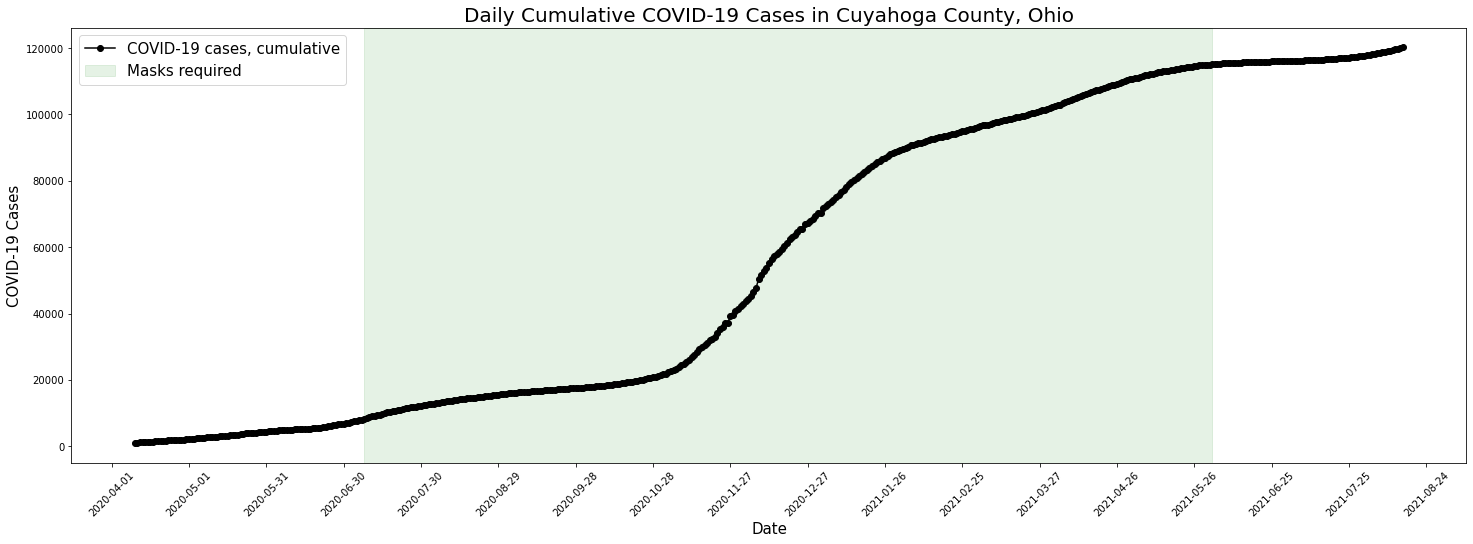

In [11]:
plt.figure(figsize=(25, 8))

plt.plot(countyDf.index, countyDf['Cases'], marker = 'o', color = "black", label = "COVID-19 cases, cumulative")
plt.title('Daily Cumulative COVID-19 Cases in Cuyahoga County, Ohio', size = 20)
plt.xlabel('Date', size = 15)
plt.xticks(countyDf.index[::30], rotation = 45)
plt.axvspan(maskStart, maskEnd, color = "green", alpha = 0.1, label = "Masks required")
plt.ylabel('COVID-19 Cases', size = 15)
plt.legend(prop={'size': 15}, loc = "upper left", ncol = 1)
plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = './viz/cumulative_cases.png')

plt.show()

Plot the derivative of the infections over time, which is the daily change in infections

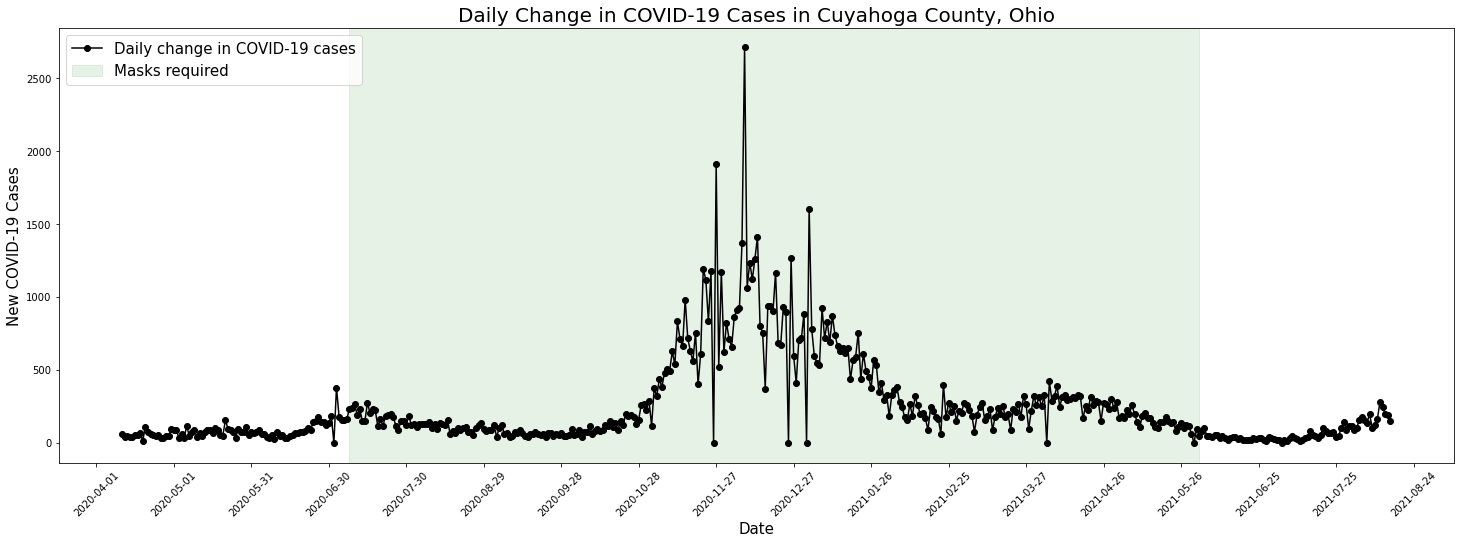

In [12]:
plt.figure(figsize=(25, 8))

plt.plot(countyDf.index, countyDf['Cases_Day_Change'], marker = 'o', color = "black", label = "Daily change in COVID-19 cases")
plt.title('Daily Change in COVID-19 Cases in Cuyahoga County, Ohio', size = 20)
plt.xlabel('Date', size = 15)
plt.xticks(countyDf.index[::30], rotation = 45)
plt.axvspan(maskStart, maskEnd, color = "green", alpha = 0.1, label = "Masks required")
plt.ylabel('New COVID-19 Cases', size = 15)
plt.legend(prop={'size': 15}, loc = "upper left", ncol = 1)
plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = './viz/new_cases.png')

plt.show()

### Step 4: Time series forecasts

In order to determine whether masking policies had an impact on COVID-19 progression in Cuyahoga, we'll create time series forecasts that assume no change in masking policy. We need 2 forecasts: one that assumes the masking requirement was never enacted, and one that assumes the masking requirement was never lifted once it was enacted. These forecasts use the CausalImpact package (https://pypi.org/project/pycausalimpact/)

First we'll create a forecast that predicts the infection rate if masking never went into effect, by trending out the pre-mask mandate data.

C:\Users\lawto\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


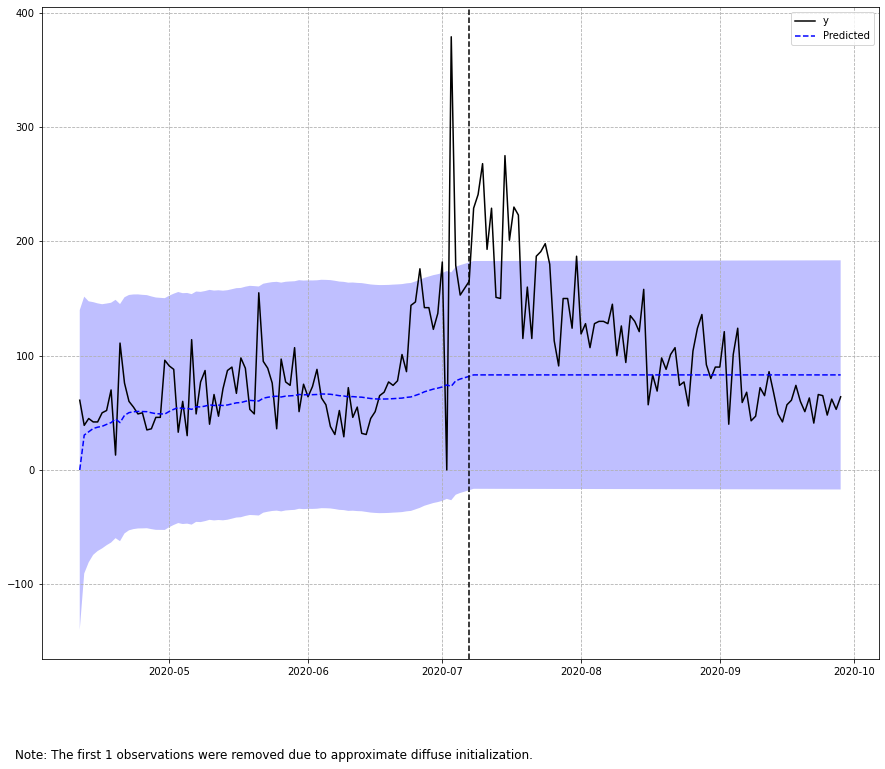

In [13]:
# Predict the impact of starting the mask mandate

# Define training data - period prior to the event
pre_period = ['2020-04-10', '2020-07-07']

# Define post-event period - i.e. time AFTER the event occurred
post_period = ['2020-07-08', '2020-09-28']

# Instantiate CI model
ci_pre = CausalImpact(countyDf['Cases_Day_Change'].loc['2020-04-10':'2021-08-15'].fillna(0), pre_period, post_period)

# Plot result
ci_pre.plot(panels = ['original'])

This forecast shows a statistically significant impact of enacting the mandate (Posterior prob. of a causal effect = 100%)

In [14]:
# Print the statistical analysis of the CI model
print(ci_pre.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    114.53             9506.0
Prediction (s.d.)         83.15 (9.24)       6901.76 (767.3)
95% CI                    [64.98, 101.22]    [5393.46, 8401.21]

Absolute effect (s.d.)    31.38 (9.24)       2604.24 (767.3)
95% CI                    [13.31, 49.55]     [1104.79, 4112.54]

Relative effect (s.d.)    37.73% (11.12%)    37.73% (11.12%)
95% CI                    [16.01%, 59.59%]   [16.01%, 59.59%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Next we'll create a forecast that predicts the infection rate if the masking mandate is never lifted. This forecast uses data from the start of the masking mandate, until the end of the mandate, to make predictions.

C:\Users\lawto\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


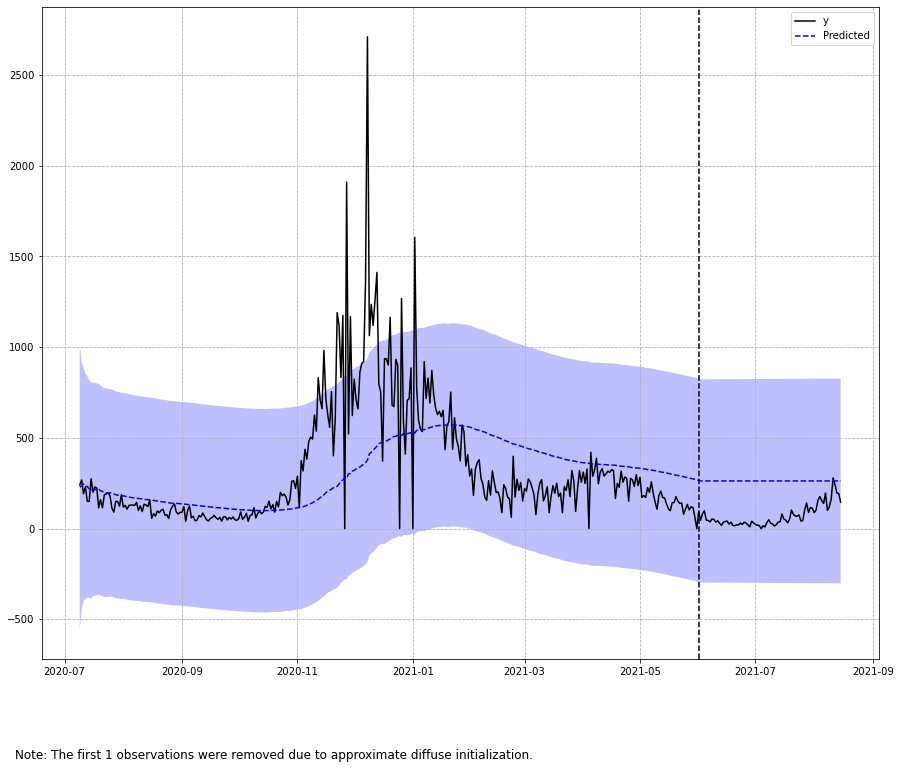

In [15]:
# Predict the impact of ending the mask mandate

# Define training data - period prior to the event
pre_period = ['2020-07-08', '2021-06-01']

# Define post-event period - i.e. time AFTER the event occurred
post_period = ['2021-06-02', '2021-08-15']

# Instantiate CI model
ci_post = CausalImpact(countyDf['Cases_Day_Change'].loc['2020-04-10':'2021-08-15'].fillna(0), pre_period, post_period)

# Plot results
ci_post.plot(panels=['original'])

This forecast also shows a statistically significant impact of ending the mandate (Posterior prob. of a causal effect = 100%)

In [16]:
# Print the statistical analysis of the CI model
print(ci_post.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    68.77              5158.0
Prediction (s.d.)         262.94 (53.97)     19720.77 (4047.92)
95% CI                    [152.45, 364.02]   [11433.63, 27301.19]

Absolute effect (s.d.)    -194.17 (53.97)    -14562.77 (4047.92)
95% CI                    [-295.24, -83.68]  [-22143.19, -6275.63]

Relative effect (s.d.)    -73.84% (20.53%)   -73.84% (20.53%)
95% CI                    [-112.28%, -31.82%][-112.28%, -31.82%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Finally, we plot these predictions in comparison to the actual observations

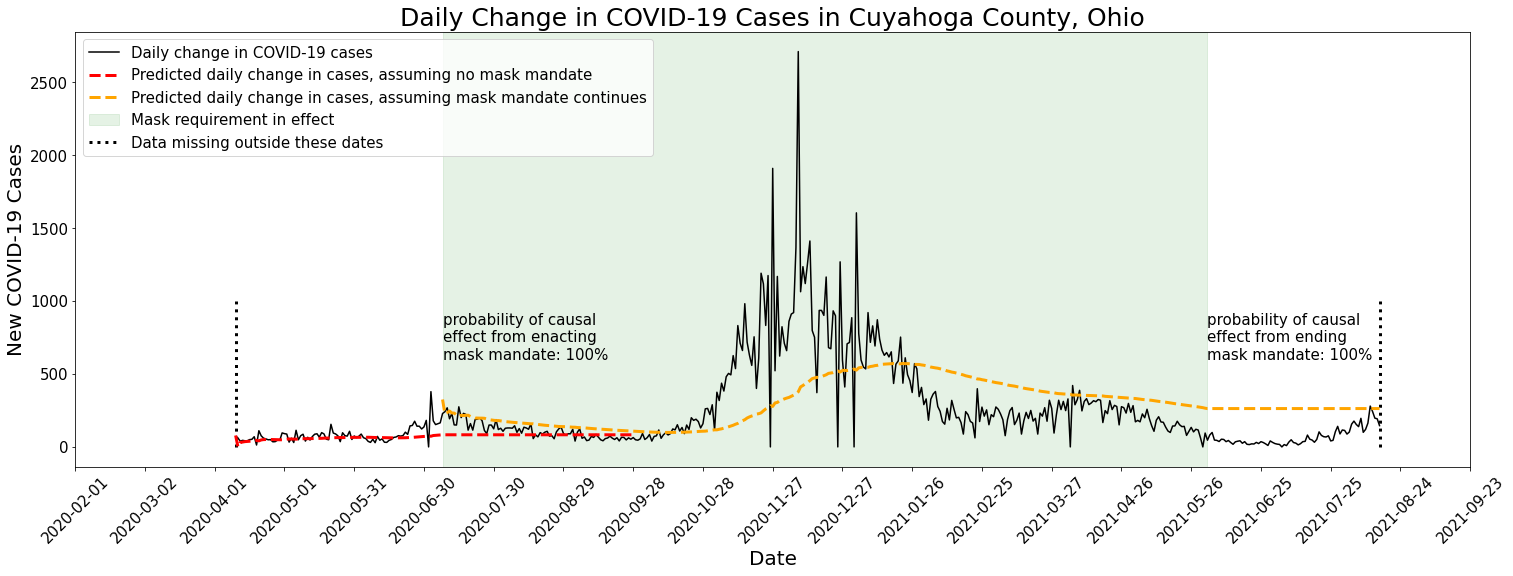

In [17]:
plt.figure(figsize=(25, 8))

plt.plot(countyDf.index, countyDf['Cases_Day_Change'], color = "black", label = "Daily change in COVID-19 cases")
plt.plot(ci_pre.inferences.index, ci_pre.inferences['preds'], linewidth = 3, linestyle = "--", color = "red", label = "Predicted daily change in cases, assuming no mask mandate")
plt.plot(ci_post.inferences.index, ci_post.inferences['preds'], linewidth = 3, linestyle = "--", color = "orange", label = "Predicted daily change in cases, assuming mask mandate continues")
plt.title('Daily Change in COVID-19 Cases in Cuyahoga County, Ohio', size = 25)
plt.vlines(x='2020-04-10', ymin = 0, ymax = 1000, colors='black', linewidth = 3, linestyles='dotted', label='Data missing outside these dates')
plt.vlines(x='2021-08-15', ymin = 0, ymax = 1000, colors='black', linewidth = 3, linestyles='dotted')
plt.annotate("probability of causal\neffect from enacting\nmask mandate: 100%", (maskStart,600), size=15)
plt.annotate("probability of causal\neffect from ending\nmask mandate: 100%", (maskEnd,600), size=15)
plt.axvspan(maskStart, maskEnd, color = "green", alpha = 0.1, label = "Mask requirement in effect")
plt.ylabel('New COVID-19 Cases', size = 20)
plt.xlabel('Date', size = 20)
plt.yticks(size = 15)
plt.xticks(countyDf.index[::30], rotation = 45, size = 15)
plt.legend(prop={'size': 15}, loc = "upper left", ncol = 1)
plt.ticklabel_format(axis="y", style="plain")
plt.savefig(fname = './viz/day_change_preds.png')

plt.show()

# Part 2: Is there a relationship between COVID-19 infections and unemployment in Cuyahoga?

In this analysis, we want to determine whether unemployment moved in tandem with changes in infection rates in Cuyahoga. It seems feasible that major increases or decreases in infections would lead to more or fewer people working, but it's also possible that unemployment is dictated by large-scale policy changes and not discrete shifts in infection rate.

### Step 1: Data prep
We'll use our case data above along with unemployment data on all counties in the Cleveland-Elyria metro area gathered from FRED (https://fred.stlouisfed.org/series/CLEV439URN), loading the individual files and then merge them together

In [18]:
# load in data in unemployment in each county
unemp_cuyahoga = pd.read_csv("./data/unemp_cuyahoga.csv")
unemp_geauga = pd.read_csv("./data/unemp_geauga.csv")
unemp_lake = pd.read_csv("./data/unemp_lake.csv")
unemp_lorain = pd.read_csv("./data/unemp_lorain.csv")
unemp_medina = pd.read_csv("./data/unemp_medina.csv")

# also load the data for the whole metro area
unemp_metro = pd.read_csv("./data/unemp_metro.csv")

# combine the datasets
unempDf = unemp_cuyahoga.merge(unemp_geauga).merge(unemp_lake).merge(unemp_lorain).merge(unemp_medina).merge(unemp_metro)

# index the df on date
unempDf.DATE = pd.to_datetime(unempDf.DATE)
unempDf.set_index('DATE', inplace=True)

# give the columns intuitive names
unempDf.rename(columns = {'OHCUYA5URN':'Unemp_Cuyahoga',
                          'OHGEAU5URN':'Unemp_Geauga',
                          'OHLAKE2URN':'Unemp_Lake',
                          'OHLORA3URN':'Unemp_Lorain',
                          'OHMEDI0URN':'Unemp_Medina',
                          'CLEV439URN':'Unemp_Metro'}, inplace=True)

Next we calculate the monthly changes in unemployment using time series shifts

In [19]:
# calculate monthly change in unemployment
unempDf['Unemp_Cuyahoga_Prev'] = unempDf.Unemp_Cuyahoga.shift(1)
unempDf['Unemp_Geauga_Prev'] = unempDf.Unemp_Geauga.shift(1)
unempDf['Unemp_Lake_Prev'] = unempDf.Unemp_Lake.shift(1)
unempDf['Unemp_Lorain_Prev'] = unempDf.Unemp_Lorain.shift(1)
unempDf['Unemp_Medina_Prev'] = unempDf.Unemp_Medina.shift(1)
unempDf['Unemp_Metro_Prev'] = unempDf.Unemp_Metro.shift(1)
unempDf['Unemp_Cuyahoga_Change'] = unempDf['Unemp_Cuyahoga'] - unempDf['Unemp_Cuyahoga_Prev']
unempDf['Unemp_Geauga_Change'] = unempDf['Unemp_Geauga'] - unempDf['Unemp_Geauga_Prev']
unempDf['Unemp_Lake_Change'] = unempDf['Unemp_Lake'] - unempDf['Unemp_Lake_Prev']
unempDf['Unemp_Lorain_Change'] = unempDf['Unemp_Lorain'] - unempDf['Unemp_Lorain_Prev']
unempDf['Unemp_Medina_Change'] = unempDf['Unemp_Medina'] - unempDf['Unemp_Medina_Prev']
unempDf['Unemp_Metro_Change'] = unempDf['Unemp_Metro'] - unempDf['Unemp_Metro_Prev']

Finally we aggregate our previous daily infection data at a monthly level, and merge it with the unemployment data

In [20]:
# format the county data into monthly sums of cases
covidDf = countyDf[['Cases']].resample('MS').sum()

# calculate the change in cases per month
covidDf['Cases_Prev'] = covidDf.Cases.shift(1)
covidDf['Cases_Change'] = covidDf['Cases'] - covidDf['Cases_Prev']

# merge the two datasets
casesDf = covidDf.merge(unempDf, left_index = True, right_index = True)

# keep only the useful columns
casesDf = casesDf[['Cases','Cases_Change',
                   'Unemp_Cuyahoga','Unemp_Cuyahoga_Change',
                   'Unemp_Geauga','Unemp_Geauga_Change',
                   'Unemp_Lake','Unemp_Lake_Change',
                   'Unemp_Lorain','Unemp_Lorain_Change',
                   'Unemp_Medina','Unemp_Medina_Change',
                   'Unemp_Metro','Unemp_Metro_Change']]

# limit the date ranges, since for some we have no or partial data
casesDf = casesDf.loc[(casesDf.index < '2021-08-01') & (casesDf.index > '2020-02-01')]

### Step 2: Correlation of unemployment vs. infection rate

To determine whether unemployment and infection rate are correlated, we'll calculate the Pearson correlation for the variables. Since infection rate might be a leading indicator for unemployment, we'll also calculate the correlation at incremental monthly shifts

To start we create a helper function for plotting our two data series along with their calculated correlation

In [21]:
# create a function for creating the same plot multiple times with different lags
def corPlot(shift):
    
    series = casesDf['Unemp_Cuyahoga_Change'].shift(shift)
    corr = series.corr(casesDf['Cases_Change'])
    
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:red'
    ax1.set_title("Monthly Change in COVID-19 Cases vs. Unemployment Rate (Shifted {0})".format(shift), fontsize = 15)
    ax1.set_xlabel('Month', fontsize = 12)
    ax1.set_ylabel('Change in COVID-19 Cases', color=color, fontsize = 12)
    ax1.plot(casesDf.index, casesDf['Cases_Change'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=45)

    ax1.annotate("Correlation: {0}".format(round(corr,2)),('2021-03-01',800000), size=15)

    ax2 = ax1.twinx() # create 2nd axis

    color = 'tab:blue'
    ax2.set_ylabel('Change in Unemployment Rate (%)\nShifted {0}'.format(shift), color=color, fontsize = 12)
    ax2.plot(casesDf.index, series, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-5.0, 20.0])

    fig.tight_layout()
    plt.show()

Plotting the data with no shifts shows a very low correlation (-0.07)

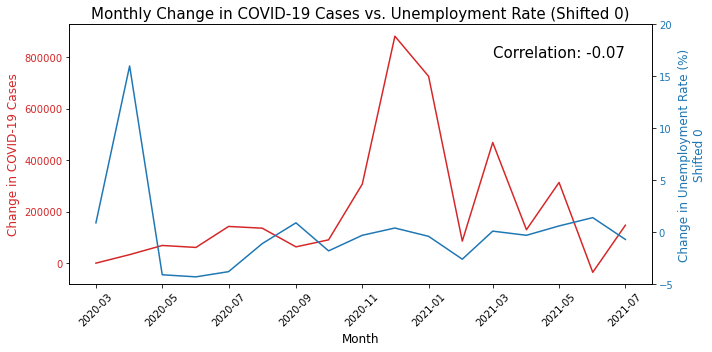

In [22]:
corPlot(0)

Incremental shifts show the correlation increasing, peaking at a shift of 5 months - evidence that there may be a ~5 month lag for unemployment catching up to changes in infection rates, though this could be coincidental

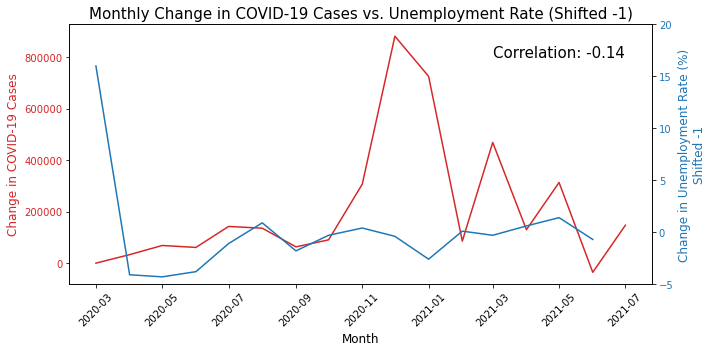

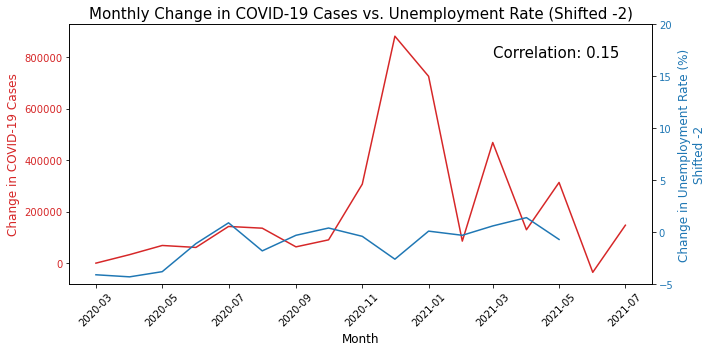

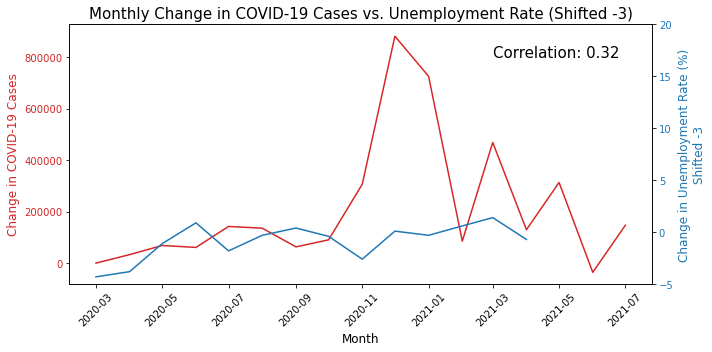

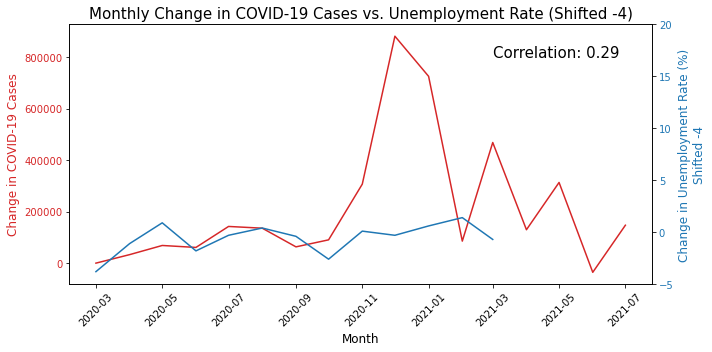

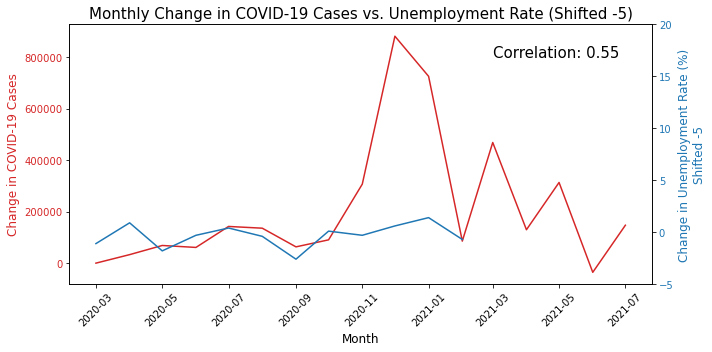

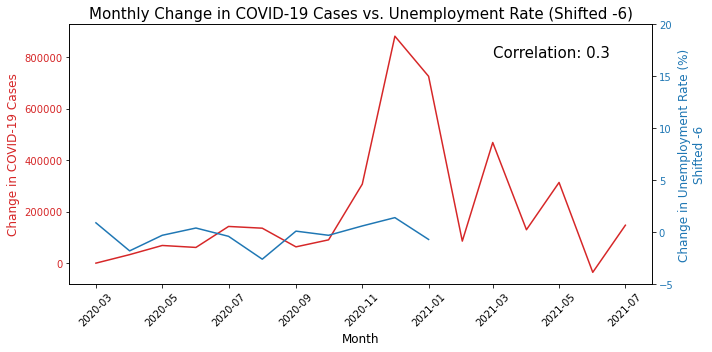

In [23]:
corPlot(-1)
corPlot(-2)
corPlot(-3)
corPlot(-4)
corPlot(-5)
corPlot(-6)

## Part 3: Was employment in Cuyahoga impacted more by COVID-19 than the other counties in the Cleveland-Elyria metropolitan area?

Cuyahoga is the most populous county in the Cleveland Elyria metro area. We want to understand whether Cuyahoga was impacted differently from other counties in terms of unemployment - specifically, whether unemployment was higher or lower, and whether change in unemployment was faster or slower. To do this we need to evaluate 2 things:

* Whether the observed values for unemployment rate in Cuyahoga were the same as other counties
* Whether the directional trend of unemployment rates in Cuyahoga are the same as other counties

### Step 1: Fit regressions to unemployment time series

We'll use OLS regressions to answer this question. To facilitate this, we create a new dataframe where dates are converted into a series of integers

In [24]:
# create an array of integers to represent our time periods
time = pd.DataFrame(np.arange(casesDf.index.size - 1))

# create a new dataframe with the time period we want (leaving out the first observation, before unemployment peaked)
uDf = casesDf[1:17].set_index(np.arange(casesDf.index.size - 1))

# assign the date & time variables to this new df
uDf['Date'] = casesDf.index[1:17]
uDf['Time'] = np.arange(casesDf.index.size - 1)

Create the regressions for unemployment in each county over time

In [25]:
# create regressions for unemployment in each county
est_cuyahoga = smf.ols(formula = 'Unemp_Cuyahoga ~ Time + 1', data = uDf)
est_geauga = smf.ols(formula = 'Unemp_Geauga ~ Time + 1', data = uDf)
est_lake = smf.ols(formula = 'Unemp_Lake ~ Time + 1', data = uDf)
est_lorain = smf.ols(formula = 'Unemp_Lorain ~ Time + 1', data = uDf)
est_medina = smf.ols(formula = 'Unemp_Medina ~ Time + 1', data = uDf)

Get the results of our regressions. Although model fit is a secondary concern in this exercise (we really just want to care slopes), we can see that all of the regressions have decent R-squared values, and statistically significant relationships between unemployment rate and time

In [26]:
# observe results for our regressions
def getOLSResults(est):
    res = est.fit()
    print(res.summary())
    return res

res_cuyahoga = getOLSResults(est_cuyahoga)
res_geauga = getOLSResults(est_geauga)
res_lake = getOLSResults(est_lake)
res_lorain = getOLSResults(est_lorain)
res_medina = getOLSResults(est_medina)

                            OLS Regression Results                            
Dep. Variable:         Unemp_Cuyahoga   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     29.19
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           9.32e-05
Time:                        20:16:02   Log-Likelihood:                -38.528
No. Observations:                  16   AIC:                             81.06
Df Residuals:                      14   BIC:                             82.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.7728      1.372     11.493      0.0

C:\Users\lawto\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\lawto\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\lawto\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\lawto\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\lawto\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  w

### Step 2: Visualize the results of the regressions

Plot what unemployment looks like in Cuyahoga vs. the OLS model. We can observe the model does a pretty good job of capturing the overall trend of unemployment over time.

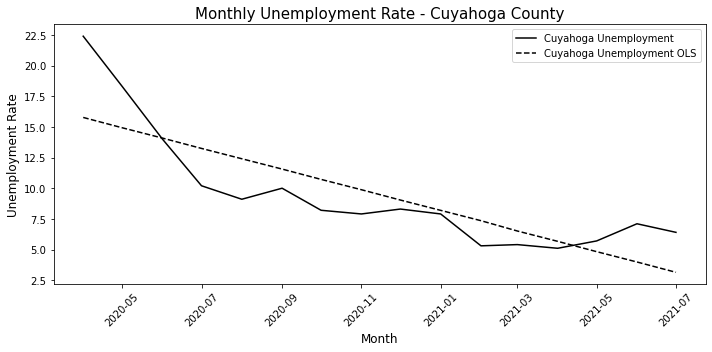

In [27]:
p = res_cuyahoga.params
t = uDf['Date']
x = uDf['Time']
y = uDf['Unemp_Cuyahoga']

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title("Monthly Unemployment Rate - Cuyahoga County", fontsize = 15)
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Unemployment Rate', color='black', fontsize = 12)
ax.plot(t, y, color='black', label='Cuyahoga Unemployment')
ax.plot(t, p.Intercept + p.Time * x, color='black', linestyle='--', label='Cuyahoga Unemployment OLS')
ax.legend(prop={'size': 10}, loc = "upper right", ncol = 1)
ax.tick_params(axis='y')
ax.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

Plot the comparison of Cuyahoga's actual and modeled unemployment vs. the other counties. Before any statistical testing, there are some clear observations:

* Cuyahoga has higher unemployment than all other counties - only Lorain looks close
* The regression lines appear to have similar slopes
* The biggest disparity in actual values and slope seems to be between Cuyahoga and Geauga

In [28]:
def plotOLSComparison(res, data, name, color):
    p1 = res_cuyahoga.params
    p2 = res.params
    t = uDf['Date']
    x = uDf['Time']
    y1 = uDf['Unemp_Cuyahoga']
    y2 = data

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.set_title("Monthly Unemployment Rate - Cuyahoga vs. {0} County".format(name), fontsize = 15)
    ax.set_xlabel('Month', fontsize = 12)
    ax.set_ylabel('Unemployment Rate', color='black', fontsize = 12)
    ax.plot(t, y1, color='black', label='Cuyahoga Unemployment')
    ax.plot(t, p1.Intercept + p1.Time * x, color='black', linestyle='--', label='Cuyahoga Unemployment OLS')
    ax.plot(t, y2, color=color, label='{0} Unemployment'.format(name))
    ax.plot(t, p2.Intercept + p2.Time * x, color=color, linestyle='--', label='{0} Unemployment OLS'.format(name))
    ax.legend(prop={'size': 10}, loc = "upper right", ncol = 1)
    ax.tick_params(axis='y')
    ax.tick_params(axis='x', rotation=45)

    fig.tight_layout()
    plt.show()

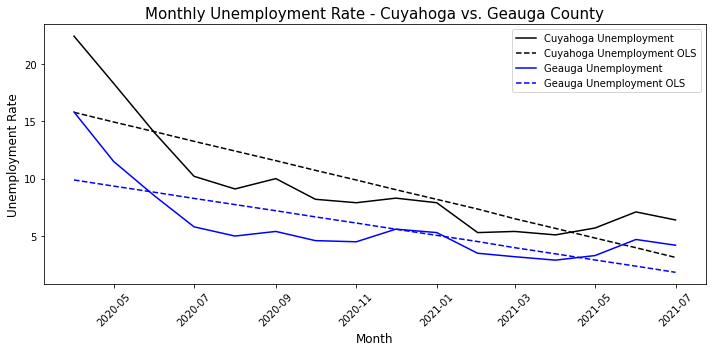

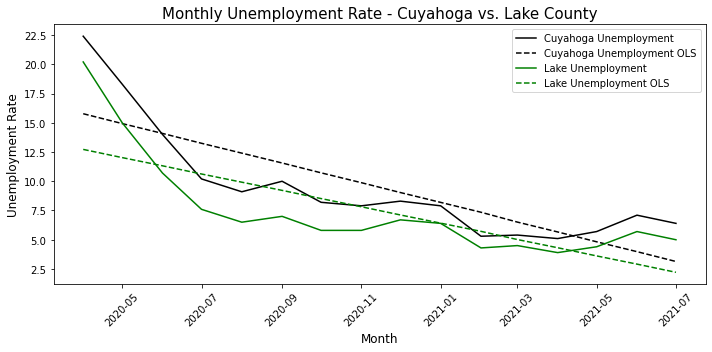

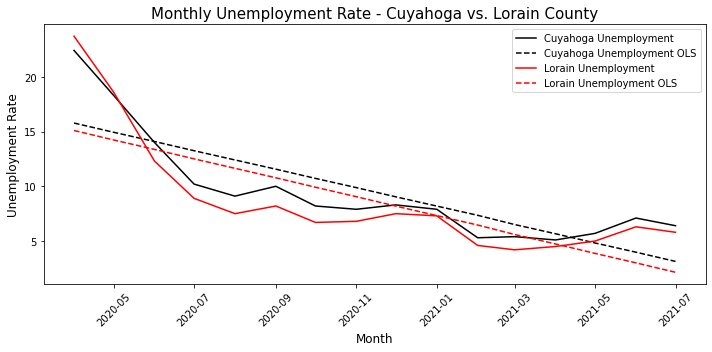

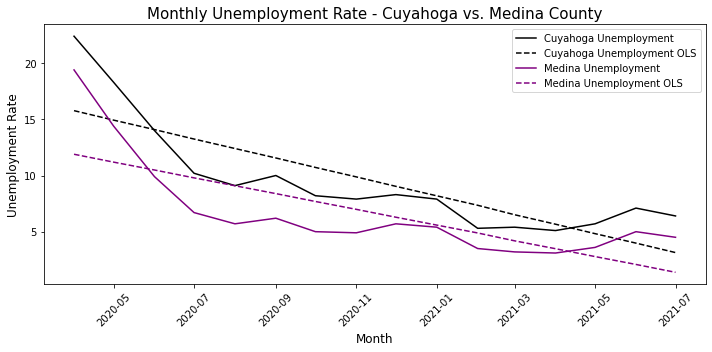

In [29]:
plotOLSComparison(res_geauga, uDf['Unemp_Geauga'], 'Geauga', 'blue')
plotOLSComparison(res_lake, uDf['Unemp_Lake'], 'Lake', 'green')
plotOLSComparison(res_lorain, uDf['Unemp_Lorain'], 'Lorain', 'red')
plotOLSComparison(res_medina, uDf['Unemp_Medina'], 'Medina', 'purple')

### Step 3: Determine the statistical signifiance of differences in unemployment values

To determine statistical significance of the county on our unemployment values, we need to restructure our data so that we can include 'County' as a regression variable

In [30]:
# to facilitate these comparisons we need a dataframe in long format
longDf = uDf[['Time','Unemp_Cuyahoga','Unemp_Geauga','Unemp_Lake','Unemp_Lorain','Unemp_Medina']] \
    .rename(columns = {'Unemp_Cuyahoga':'Cuyahoga','Unemp_Geauga':'Geauga','Unemp_Lake':'Lake','Unemp_Lorain':'Lorain','Unemp_Medina':'Medina'}) \
    .melt(id_vars=['Time'], var_name = 'County', value_name = 'Unemployment')

Now we create new regressions of unemployment on time and county and observe the results

In [31]:
# create regressions for unemployment in each county, including county to determine stat. sig. of the shift
est_shift_geauga = smf.ols(formula = 'Unemployment ~ 1 + Time + County', data = longDf[longDf['County'].isin({'Cuyahoga','Geauga'})])
est_shift_lake = smf.ols(formula = 'Unemployment ~ 1 + Time + County', data = longDf[longDf['County'].isin({'Cuyahoga','Lake'})])
est_shift_lorain = smf.ols(formula = 'Unemployment ~ 1 + Time + County', data = longDf[longDf['County'].isin({'Cuyahoga','Lorain'})])
est_shift_medina = smf.ols(formula = 'Unemployment ~ 1 + Time + County', data = longDf[longDf['County'].isin({'Cuyahoga','Medina'})])

In [32]:
res_shift_geauga = getOLSResults(est_shift_geauga)
res_shift_lake = getOLSResults(est_shift_lake)
res_shift_lorain = getOLSResults(est_shift_lorain)
res_shift_medina = getOLSResults(est_shift_medina)

                            OLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     29.68
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           9.64e-08
Time:                        20:16:04   Log-Likelihood:                -75.375
No. Observations:                  32   AIC:                             156.8
Df Residuals:                      29   BIC:                             161.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.6252      1.021  

We want to determine whether these results are statistically significant. Since we're doing 4 tests at once, we need to correct our alpha level using a Bonferroni correction to mitigate the possibility of type 1 error. Doing this we observe that Geauga and Medina have significantly different values for unemployment

In [33]:
alpha = 0.05
alpha_bonf = 0.05 / 4
print("Alpha = {0}, divided by 4 for Bonferroni correction = {1}".format(alpha, alpha_bonf))

def getStatSig(name, value, type, alpha):
    print("P-value for difference in Cuyahoga vs. {0} unemployment {1}: {2}".format(name, type, round(value,4)))
    print("\tStatistically significant at the {0} level? {1}".format(alpha, value < alpha))
    
getStatSig('Geauga',res_shift_geauga.pvalues[1], 'values', alpha_bonf)
getStatSig('Lake',res_shift_lake.pvalues[1], 'values', alpha_bonf)
getStatSig('Lorain',res_shift_lorain.pvalues[1], 'values', alpha_bonf)
getStatSig('Medina',res_shift_medina.pvalues[1], 'values', alpha_bonf)

Alpha = 0.05, divided by 4 for Bonferroni correction = 0.0125
P-value for difference in Cuyahoga vs. Geauga unemployment values: 0.0007
	Statistically significant at the 0.0125 level? True
P-value for difference in Cuyahoga vs. Lake unemployment values: 0.0605
	Statistically significant at the 0.0125 level? False
P-value for difference in Cuyahoga vs. Lorain unemployment values: 0.4626
	Statistically significant at the 0.0125 level? False
P-value for difference in Cuyahoga vs. Medina unemployment values: 0.0104
	Statistically significant at the 0.0125 level? True


We get statistically significant differences for Geauga and Medina, but are we sure this is an impact of COVID? If we look at unemployment rates pre-COVID, Cuyahoga is also higher than Geauga and Medina

In [68]:
# create a df of unemployment rates in the 6 months prior to our COVID-impacted data
unempPre = unempDf[unempDf.index < '2020-03-01']
unempPre = unempPre[unempPre.index > '2019-8-01']

# print pre-COVID unemployment rates
print("Cuyahoga Pre-COVID Unemployment (6-Month Avg): {0}".format(unempPre['Unemp_Cuyahoga'].mean(axis = 0)))
print("Geauga Pre-COVID Unemployment (6-Month Avg): {0}".format(unempPre['Unemp_Geauga'].mean(axis = 0)))
print("Lake Pre-COVID Unemployment (6-Month Avg): {0}".format(unempPre['Unemp_Lake'].mean(axis = 0)))
print("Lorain Pre-COVID Unemployment (6-Month Avg): {0}".format(unempPre['Unemp_Lorain'].mean(axis = 0)))
print("Medina Pre-COVID Unemployment (6-Month Avg): {0}".format(unempPre['Unemp_Medina'].mean(axis = 0)))

Cuyahoga Pre-COVID Unemployment (6-Month Avg): 4.183333333333334
Geauga Pre-COVID Unemployment (6-Month Avg): 3.533333333333333
Lake Pre-COVID Unemployment (6-Month Avg): 3.75
Lorain Pre-COVID Unemployment (6-Month Avg): 4.366666666666666
Medina Pre-COVID Unemployment (6-Month Avg): 3.4666666666666663


### Step 4: Determine the significance of differences in regression slopes
This will tell us whether the overall rate of change of unemployment during the pandemic was different in Cuyahoga vs. other counties

This time we have to include the interaction term of Time * County in our regression. The p-value for this term will tell us whether there's a statistically significant difference in rate of change of unemployment for Cuyahoga vs. the other county.

In [34]:
# create regressions for unemployment in each county, including county to determine stat. sig. of the slope
est_slope_geauga = smf.ols(formula = 'Unemployment ~ 1 + Time + County + Time * County', data = longDf[longDf['County'].isin({'Cuyahoga','Geauga'})])
est_slope_lake = smf.ols(formula = 'Unemployment ~ 1 + Time + County + Time * County', data = longDf[longDf['County'].isin({'Cuyahoga','Lake'})])
est_slope_lorain = smf.ols(formula = 'Unemployment ~ 1 + Time + County + Time * County', data = longDf[longDf['County'].isin({'Cuyahoga','Lorain'})])
est_slope_medina = smf.ols(formula = 'Unemployment ~ 1 + Time + County + Time * County', data = longDf[longDf['County'].isin({'Cuyahoga','Medina'})])

In [35]:
res_slope_geauga = getOLSResults(est_slope_geauga)
res_slope_lake = getOLSResults(est_slope_lake)
res_slope_lorain = getOLSResults(est_slope_lorain)
res_slope_medina = getOLSResults(est_slope_medina)

                            OLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     21.46
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           2.03e-07
Time:                        20:16:04   Log-Likelihood:                -74.103
No. Observations:                  32   AIC:                             156.2
Df Residuals:                      28   BIC:                             162.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                15.77

Observing these results, we can see that Cuyahoga doesn't have a statistically significant difference in slope vs. any of the other counties.

In [36]:
getStatSig('Geauga',res_slope_geauga.pvalues[3], 'values', alpha_bonf)
getStatSig('Lake',res_slope_lake.pvalues[3], 'values', alpha_bonf)
getStatSig('Lorain',res_slope_lorain.pvalues[3], 'values', alpha_bonf)
getStatSig('Medina',res_slope_medina.pvalues[3], 'values', alpha_bonf)

P-value for difference in Cuyahoga vs. Geauga unemployment values: 0.1391
	Statistically significant at the 0.0125 level? False
P-value for difference in Cuyahoga vs. Lake unemployment values: 0.5302
	Statistically significant at the 0.0125 level? False
P-value for difference in Cuyahoga vs. Lorain unemployment values: 0.9336
	Statistically significant at the 0.0125 level? False
P-value for difference in Cuyahoga vs. Medina unemployment values: 0.5354
	Statistically significant at the 0.0125 level? False


### Step 5: Visualize results

We take the initial charts above but add in annotations for our p-values to create a final comprehensive visualization

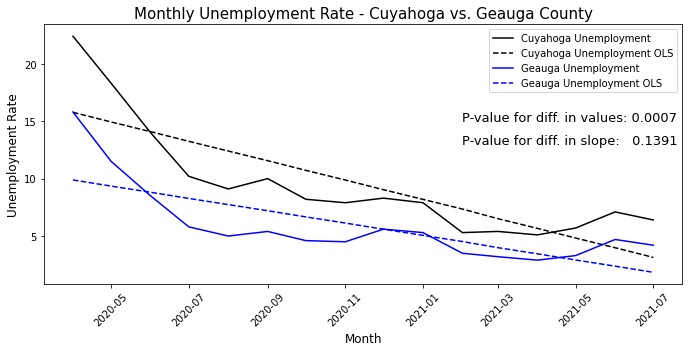

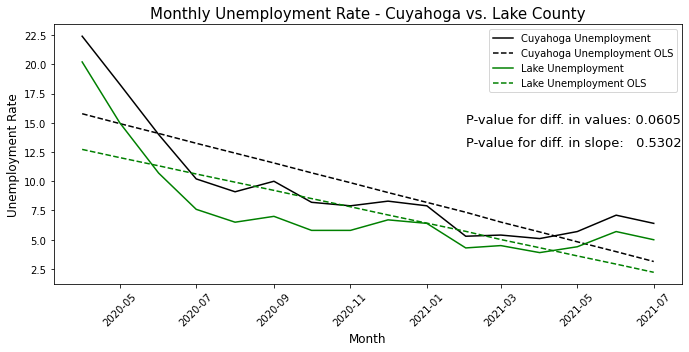

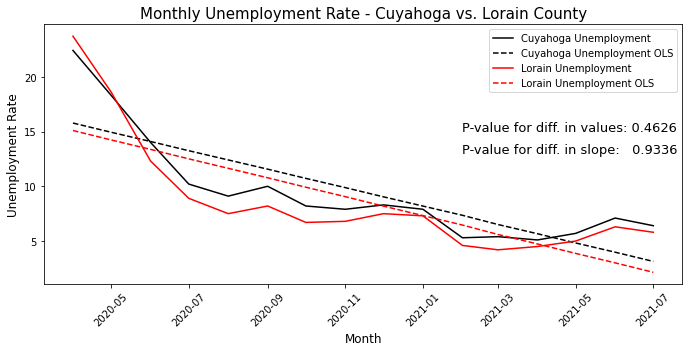

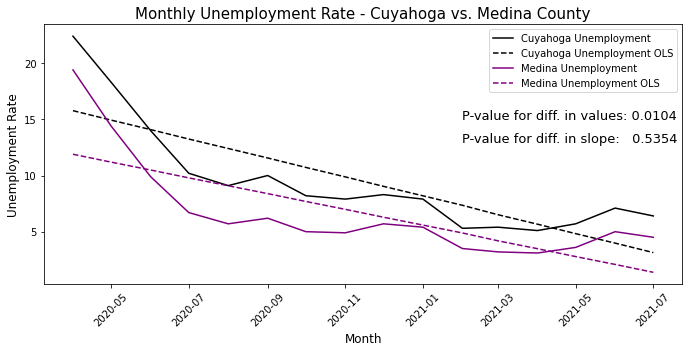

In [38]:
def plotOLSComparisonExt(res, data, name, color, pv1, pv2):
    p1 = res_cuyahoga.params
    p2 = res.params
    t = uDf['Date']
    x = uDf['Time']
    y1 = uDf['Unemp_Cuyahoga']
    y2 = data

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.set_title("Monthly Unemployment Rate - Cuyahoga vs. {0} County".format(name), fontsize = 15)
    ax.set_xlabel('Month', fontsize = 12)
    ax.set_ylabel('Unemployment Rate', color='black', fontsize = 12)
    ax.plot(t, y1, color='black', label='Cuyahoga Unemployment')
    ax.plot(t, p1.Intercept + p1.Time * x, color='black', linestyle='--', label='Cuyahoga Unemployment OLS')
    ax.plot(t, y2, color=color, label='{0} Unemployment'.format(name))
    ax.plot(t, p2.Intercept + p2.Time * x, color=color, linestyle='--', label='{0} Unemployment OLS'.format(name))
    ax.legend(prop={'size': 10}, loc = "upper right", ncol = 1)
    ax.tick_params(axis='y')
    ax.tick_params(axis='x', rotation=45)
    
    ax.annotate("P-value for diff. in values: {0}".format(round(pv1,4)), ('2021-02-01',15), size=13)
    ax.annotate("P-value for diff. in slope:   {0}".format(round(pv2,4)), ('2021-02-01',13), size=13)

    fig.tight_layout()
    plt.show()

plotOLSComparisonExt(res_geauga, uDf['Unemp_Geauga'], 'Geauga', 'blue',res_shift_geauga.pvalues[1],res_slope_geauga.pvalues[3])
plotOLSComparisonExt(res_lake, uDf['Unemp_Lake'], 'Lake', 'green',res_shift_lake.pvalues[1],res_slope_lake.pvalues[3])
plotOLSComparisonExt(res_lorain, uDf['Unemp_Lorain'], 'Lorain', 'red',res_shift_lorain.pvalues[1],res_slope_lorain.pvalues[3])
plotOLSComparisonExt(res_medina, uDf['Unemp_Medina'], 'Medina', 'purple',res_shift_medina.pvalues[1],res_slope_medina.pvalues[3])